# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [36]:
# Read the relevant dataset and import pandas
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [37]:
# Import additional libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [6]:
# Display the first 10 entries of the dataset
df.head(10)

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0
5,99.2,M,83.0
6,98.0,M,71.0
7,98.8,M,78.0
8,98.4,F,84.0
9,98.6,F,86.0


In [7]:
# The dimensions of the dataset
df.shape

(130, 3)

## 1) Is the distribution of body temperatures normal? 

There are 3 conditions that have to be true for a distribution to be considered normal:

1. The population from which the data is chosen is normal. We'll have to assume that this is the case since it was established that this is a random sample.
2. The sample size must be greater than or equal to 30. The dataset sample size is 130, so that conditon is fulfilled. 
3. The ECDF and theoretical CDF should be very similar, almost identical, which we'll establish below.

In [38]:
# Create a mean, standard deviation, and random normally distributed data from the temperature dataset.
# This will be used to create a theoretical CDF. 
mean = np.mean(df.temperature)
std = np.std(df.temperature)
norm = np.random.normal(mean, std, 10000)

In [93]:
# Create ECDF function
def ecdf(data):
    '''Computes the ECDF'''
    # x values 
    x = np.sort(data)
    
    # number of values in the data
    n = len(data)
    
    # y values
    y = np.arange(1, n+1) / n
    
    return x, y

In [10]:
x, y = ecdf(df.temperature)
x_theor, y_theor = ecdf(norm)

Text(0, 0.5, 'CDF')

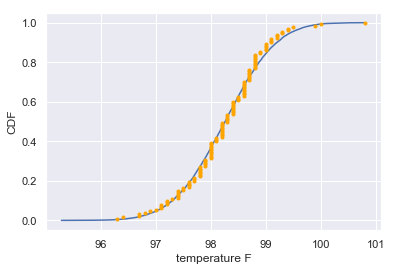

In [11]:
# PLot the ECDF of both the temperature dataset and the theoretical CDF
sns.set()
plt.plot(x_theor, y_theor)
plt.plot(x, y,  marker='.', linestyle='none', color='orange')
plt.xlabel('temperature F')
plt.ylabel('CDF')

The theoretical CDF fits the data very well, which suggests that the distribution of the body temperatures is normal.

## 2) Is the sample size large? Are the observations independent? 

As mentioned above, the sample size needs to be greater than or equal to 30 to be considered large. With the dataset containning 130 values, it meets the condition of being large.

The 10% rule states that for a the values of a sample to be considered independent, they must be less than 10% of the population. If we assume that the population is the U.S. general population, the 130 people sampled are well below 10% of that population. Therefore, we can conclude that the observations are independent. 

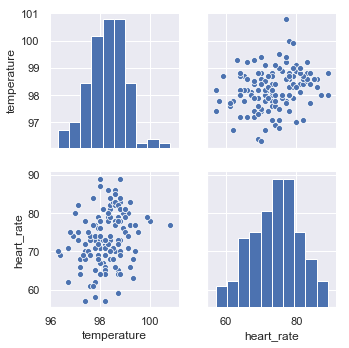

In [12]:
sns.pairplot(df)

Additonally, the above pairplot doesn't seem to suggest a strong correlation between the data, which may be another indication that the observations are independent.

## 3) Is the true population mean really 98.6 degrees F? 

### First, try a bootstrap hypothesis test

For our null hypothesis, we'll assume that the true population mean is 98.6 degrees F.
Let's begin by developing a function for generating bootstrap replicates of one dimensional data and another function that then draws the bootstrap replicates. 

In [1]:
# Bootstrap data generator takes data and a function and returns random values by applying on the function of choice
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [2]:
def draw_bs_reps(data, func, size):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate the replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [17]:
# Create data of shifted mean values for bootstrap analysis by subtracting the mean and summing by 98.6.
df['shift_temp'] = df['temperature'] - mean + 98.6

In [18]:
# Since we're considering the true mean, we'll apply the mean function to our temperature data and create 10000 replicates.
temp_bs_reps = draw_bs_reps(df.shift_temp, np.mean, 10000)

We'll calculate the p-value. If it is lower than 0.05, we'll reject the null hypothesis. 

In [30]:
# Calculate the p-value by taking the sum of all values less than the mean and dividing by the number of replicate  values. 
# Print the observed mean calculated earlier as well as the p-value.
p_value = sum(temp_bs_reps < mean)/len(temp_bs_reps)
print('The observed  mean is ' + str(mean))
print('The p-value is ' + str(p_value))

The observed  mean is 98.24923076923078
The p-value is 0.0


The p-value appears to be essentially 0, which is well below our threshold of 0.05. Therefore, we reject the null hypothesis
that the true population mean is 98.6. As the the histogram below makes clear, the observed mean is nowhere close to the 
mean of the bootstrapped data.

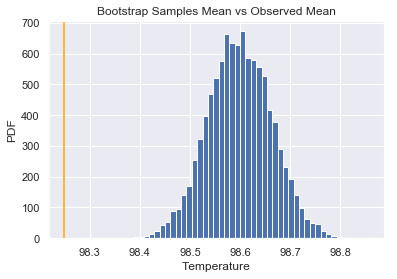

In [118]:
# Plot the histogram along with a line to indicate the observed mean
plt.hist(temp_bs_reps, bins=50)
plt.title('Bootstrap Samples Mean vs Observed Mean')
plt.xlabel('Temperature')
plt.ylabel('PDF')
plt.axvline(x=mean, color='orange')
plt.show()

### Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?

For a frequentist approach, we would use a one-sample test because we are only concerned with determining whether the true population mean is 98.6. We are not concerned with wheter it is higher or lower than than 98.6. If we did wish to determine whether it was higher or lower, a two-sample test would be more appropriate. 

### In this situation, is it appropriate to use the 𝑡 or 𝑧 statistic? 

A z statistic would be more appropriate because we are dealing with a sample size greater than 30. This, of course, assumes that the data is independent, normally distributed, and randomly selected. 

In [72]:
# First import the z-test from scipy
import scipy
from statsmodels.stats.weightstats import ztest

In [32]:
# Applying the z statistic
z_val, pz_val = ztest(df['temperature'], value=98.6)
print("The z stat is " + str(z_val)) 
print("The p-value of the z stat is " + str(pz_val))

The z stat is -5.4548232923645195
The p-value of the z stat is 4.9021570141012155e-08


The p-value, again, is well below 0.05. Thus, we, again, reject the null hypothesis. 

### Now try using the other test. How is the result different? Why? 

In [33]:
# Import the t test from scipy
from scipy.stats import ttest_1samp
# Applying the t statistic
t_val, pt_val = ttest_1samp(df['temperature'], 98.6)
print("The t stat is " + str(t_val)) 
print("The p-value of the t stat is " + str(pt_val))

The t stat is -5.4548232923645195
The p-value of the t stat is 2.4106320415561276e-07


The z and t values themselves are the same, and while both tests' p-values fall well below the 0.05 threshold,
the t test is not as small as that of the z test. What that indicates is that with the t test, we are less sure 
that we rightly rejected the null hypothesis. While the t test can be applied to larger data sets, it lowers the probablity 
of our confidence interval because the t test operates under the assumption that the population standard deviation is 
unknown.

## 4) Draw a small sample of size 10 from the data and repeat both frequentist tests. 

### Which one is the correct one to use? 

Since the sample size is 10, which is less than 30, the t statistic is the more appropriate test.

### What do you notice? What does this tell you about the difference in application of the 𝑡 and 𝑧 statistic?

In [59]:
# Pick 10 random samples from the temperature data by first seeding a number and then selecting 10 values based on the seed.
np.random.seed(89)
temp10_samp = np.random.choice(df['temperature'], 10)
temp10_samp

array([98.3, 97.3, 98.6, 97.2, 98.5, 97.5, 97.8, 97.6, 97.8, 98.7])

In [60]:
# Apply the t test to the 10 sample values
t10_val, pt10_val = ttest_1samp(temp10_samp, 98.6)
print("The t stat is " + str(t10_val)) 
print("The p-value of the t stat is " + str(pt10_val))

The t stat is -3.8252766906763593
The p-value of the t stat is 0.004056973392665601


In [61]:
# Applying the z statistic tot the same 10 values
z10_val, pz10_val = ztest(temp10_samp, value=98.6)
print("The z stat is " + str(z10_val)) 
print("The p-value of the z stat is " + str(pz10_val))

The z stat is -3.8252766906763593
The p-value of the z stat is 0.00013062529362507398


The z and t values are identical. However, their respective p-values are quite different, with the z test's p-value giving us greater confidence that the null hypothesis should be rejected. Yet, because a z test is not usually recommended for small sample sizes, we may not be able to trust its p-value as much as that of the t test. 

## 5) At what temperature should we consider someone's temperature to be "abnormal"? 

### As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach. 
### Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws. 

In [64]:
# The confidence interval of the bootstrap method. Begin by drawing 10000 replicates using the mean function
bs_reps = draw_bs_reps(df['temperature'], np.mean, 10000)

# Apply np.percentile to find the confidence interval of p < 0.05
conf_int_bs = np.percentile(bs_reps, [2.5, 97.5])
print('The 95% confidence interval for the bootstrap method is ' + str(conf_int_bs))

# The confidence interval using the frequentist approach
conf_int_freq = np.percentile(norm, [2.5, 97.5])
print('The 95% confidence interval for the frequentist approach is ' + str(conf_int_freq))

The 95% confidence interval for the bootstrap method is [98.12384615 98.37540385]
The 95% confidence interval for the frequentist approach is [96.82127368 99.7049611 ]


For the margin of error, we'll be using the formula: z * (std(n) / (len(n) ** (1/2)),  where z is the z score of the data, n. 

In [84]:
# The margin of error for the bootstrap method
marg_err_bs = ztest(x1=bs_reps, value=np.mean(bs_reps))[0] * (np.std(bs_reps) / (len(bs_reps) ** (1/2)))
print('The margin of error for the bootstrap method is ' + str(marg_err_bs))

# The margin of error for the frequentist approach
marg_err_freq = ztest(x1=norm, value=mean)[0] * (std / (len(norm) ** (1/2) ))
print('The margin of error for the frequentist approach is ' + str(marg_err_freq))

The margin of error for the bootstrap method is 0.0
The margin of error for the frequentist approach is 0.017793039199874114


The 95% confidence interval for the bootstrap method is very narrow, and anything lower than 98.12 F and higher than 98.38 F would be considered abnormal. 

However, the frequentist approach gives a more realistic interval, in which anything lower 96.82 F and higher than 99.70 F would be considered abnormal. 

## 6) Is there a significant difference between males and females in normal temperature? 

In [90]:
# Create separate temperature lists for both females and males
fem_temp = df[df['gender'] == 'F']['temperature']
ma_temp =  df[df['gender'] == 'M']['temperature']

In [116]:
# The mean temperaturesfor both females and males
fem_mean = np.mean(fem_temp)
ma_mean = np.mean(ma_temp)
print('Female mean temperature: ' + str(fem_mean))
print('Male mean temperature: ' + str(ma_mean))

Female mean temperature: 98.39384615384613
Male mean temperature: 98.1046153846154


In [96]:
# ECDF for both females and males
x_fem, y_fem = ecdf(fem_temp)
x_ma, y_ma = ecdf(ma_temp)

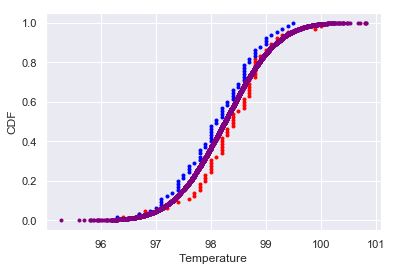

In [100]:
# Plot both female and male ECDF against the theoretical CDF to get a sense of how they differ
_ = plt.plot(x_fem, y_fem, marker='.', linestyle='none', color='red')
_ = plt.plot(x_ma, y_ma, marker='.', linestyle='none', color='blue')
_ = plt.plot(x_theor, y_theor, marker='.', linestyle='none', color='purple')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('CDF')
plt.show()

It appears that females have a higher mean temperature than men. We'll see if that holds true after a more detailed analysis

### What testing approach did you use and why? 

We'll use a permutation test because we're interested in determining whether there is significant enough difference 
between the temperatures between females and males to reject the null hypothesis that assumes that there is no significant difference.

In [91]:
# Create a permutation function
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [111]:
# Create a function to draw permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [103]:
# Finally, create a function to determine the difference of means between two arrays
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

In [117]:
# Calculate the difference of means between females and males
temp_diff = diff_of_means(fem_temp, ma_temp)
print('The difference of means betwwen female and male temperatures is ' + str(temp_diff))

The difference of means betwwen female and male temperatures is 0.289230769230727


In [113]:
# Draw 10000 replicates of fmale and male data using the difference of means function
perm_reps = draw_perm_reps(fem_temp, ma_temp, diff_of_means, 10000) 

In [114]:
# Compute the p-value based on how many of the permutation replicates are greater than the mean difference of temperature
p = np.sum(perm_reps >= temp_diff) / len(perm_reps)
print('The p-value of the difference of means between females and males is ' + str(p))

The p-value of the difference of means between females and males is 0.012


The p-value is lower than the 0.05 threshold for a 95% confidence interval. Therefore, we reject the null hypothesis 
that females and males have the same normal temperature. 

### Write a story with your conclusion in the context of the original problem. 

Overall, it appears that, based on the data and a 95% confidence interval, we have good reason to reject the idea that the mean human body temperature is 98.6 F. The above analysis indicates that it may be closer to 98.2 F. In addition, our p-value calculations suggest that that it is unlikely that females and males have the same mean temerature, with the data suggesting that the mean temperature  of females is around 98.3 F and that of males isaround 98.1 F.